In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Tentukan path folder
folder_path = "Lat_1/images"

# Nama file gambar
file_name = "Cars0.png"

# Gabungkan folder dan nama file jadi path lengkap
file_path = os.path.join(folder_path, file_name)

# 1. Load gambar
car_image = cv2.imread(file_path)

In [3]:
# 2. Grayscaling
# Mengubah gambar menjadi satu channel untuk mempermudah proses selanjutnya.
gray_car = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)

In [4]:
# 3. Noise Reduction
# Menggunakan kernel 5x5 untuk menghaluskan noise medium tanpa terlalu
# mengaburkan detail plat nomor. Median blur efektif untuk noise 'salt-and-pepper'.
blurred_car = cv2.medianBlur(gray_car, 5)

In [5]:
# 4. Contrast Enhancement
# Nilai alpha=2.0 akan membuat area putih (plat) menjadi lebih putih dan 
# area hitam (huruf) menjadi lebih hitam, sehingga perbedaannya lebih jelas.
# Beta=0 karena kita tidak perlu mengubah kecerahan secara keseluruhan.
alpha = 2.0  # Kontras
beta = 0     # Kecerahan
contrast_car = cv2.convertScaleAbs(blurred_car, alpha=alpha, beta=beta)

In [6]:
# 5. Edge Detection
# Menggunakan Canny untuk mendeteksi tepi. 
# Threshold bawah (misal, 100) akan mendeteksi tepi yang agak lemah.
# Threshold atas (misal, 200) akan mendeteksi tepi yang kuat.
# Canny akan menghubungkan tepi lemah yang tersambung ke tepi kuat.
# Nilai ini ideal untuk menangkap bentuk persegi panjang plat dan huruf di dalamnya.
edges_car = cv2.Canny(contrast_car, 100, 200)


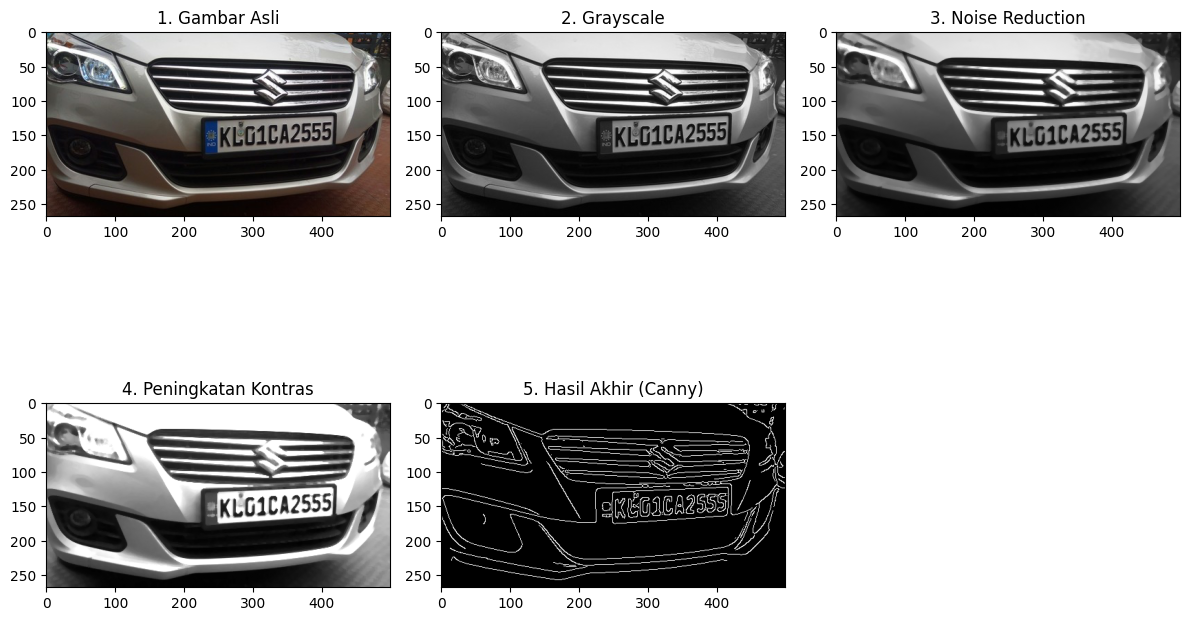

In [7]:
# Menampilkan semua langkah untuk perbandingan
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB))
plt.title('1. Gambar Asli')

plt.subplot(2, 3, 2)
plt.imshow(gray_car, cmap='gray')
plt.title('2. Grayscale')

plt.subplot(2, 3, 3)
plt.imshow(blurred_car, cmap='gray')
plt.title('3. Noise Reduction')

plt.subplot(2, 3, 4)
plt.imshow(contrast_car, cmap='gray')
plt.title('4. Peningkatan Kontras')

plt.subplot(2, 3, 5)
plt.imshow(edges_car, cmap='gray')
plt.title('5. Hasil Akhir (Canny)')

plt.tight_layout()
plt.show()


Bounding box plat nomor: x=0, y=36, w=439, h=192


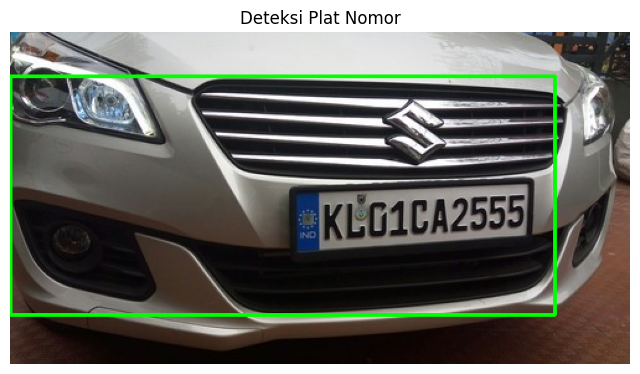

In [8]:
# Menggunakan contour detection untuk mencari bounding box plat nomor
# Asumsi: Plat nomor adalah area persegi panjang dengan tepi yang jelas pada hasil edge detection

# Temukan kontur pada hasil edge detection
contours, _ = cv2.findContours(edges_car, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Variabel untuk menyimpan bounding box terbaik
plate_bbox = None
max_area = 0

# Loop semua kontur untuk mencari kotak dengan rasio aspek dan area yang sesuai plat nomor
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h)
    area = w * h
    # Plat nomor biasanya persegi panjang (rasio aspek antara 2 dan 6) dan area cukup besar
    if 2 < aspect_ratio < 6 and area > max_area and area > 1000:
        plate_bbox = (x, y, w, h)
        max_area = area

# Visualisasi hasil deteksi bounding box pada gambar asli
output_image = car_image.copy()
if plate_bbox:
    x, y, w, h = plate_bbox
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    print(f"Bounding box plat nomor: x={x}, y={y}, w={w}, h={h}")
else:
    print("Plat nomor tidak ditemukan.")

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title('Deteksi Plat Nomor')
plt.axis('off')
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model CNN sederhana untuk deteksi plat nomor (klasifikasi/segmentasi sederhana)
model = models.Sequential([
    layers.Input(shape=(64, 128, 1)),  # Asumsi input gambar plat nomor grayscale 64x128
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output: 1 (plat nomor) atau 0 (bukan)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/Users/kikypradini/miniconda3/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/kikypradini/miniconda3/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/kikypradini/miniconda3/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update th

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,081 (8.35 MB)

 Trainable params: 2,190,081 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Melatih model CNN dengan data dummy (misal, X_train dan y_train sudah disiapkan)
# Gantilah X_train dan y_train dengan data pelatihan sebenarnya jika sudah tersedia

# Contoh dummy data untuk ilustrasi (jangan gunakan untuk training sebenarnya)
# X_train = np.random.rand(100, 64, 128, 1)
# y_train = np.random.randint(0, 2, 100)

# model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Catatan: Gantilah X_train dan y_train dengan dataset plat nomor yang sudah diproses.
print("Untuk melatih model, gunakan parameter epochs pada fungsi fit, misal: model.fit(X_train, y_train, epochs=10)")

Untuk melatih model, gunakan parameter epochs pada fungsi fit, misal: model.fit(X_train, y_train, epochs=10)
